In [12]:
import torch
import torch.nn as nn
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, PowerTransformer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline

df = pd.read_csv('../Time Series Data/time_series_covid_19_confirmed.csv')
df.dropna(inplace = True)
x = np.arange('2020-01-22', '2020-04-21', dtype = 'datetime64[D]')
#df['Country/Region Code'] = df['Country/Region'].astype('category').cat.codes.values
#df['Province/State Code'] =  df['Province/State'].astype('category').cat.codes.values
a = df.drop(['Country/Region', 'Province/State', 'Lat', 'Long'], axis = 1, inplace  = False)
df2 = pd.DataFrame()
for i,name in enumerate(df['Country/Region']):
    df2[name + " : " + df['Province/State'].iloc[i]] = a.iloc[i]
    

In [67]:
def plotGraph(name):
    plt.figure(figsize = (12,10))
    plt.title(name)
    plt.plot(df2[name])
    plt.autoscale(axis='x',tight=True)
    plt.xlim(('3/13/20','4/2/20'))

def test_train(name,test_size,num):
    m = df2[name].values.astype(float)
    train_set = m[num:-test_size]
    test_set = m[-test_size:]
    return train_set, test_set

def input_data(seq,ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out


    scaler = PowerTransformer(method='box-cox', standardize=False)
    x_norm2 = scaler.fit_transform(train_set.reshape(-1,1))
    train_norms = torch.FloatTensor(x_norm2).view(-1)
    

def training(epoch, train_data, losses):
    for i in range(epoch):
        for seq,y_train in train_data:
            optimizer.zero_grad()
            model.hidden = (torch.zeros(1,1,model.hidden_size), torch.zeros(1,1,model.hidden_size))
            y_pred = model(seq)
            loss = torch.sqrt(criterion(y_pred, y_train))
            loss.backward()
            optimizer.step()
        print(f'epoch: {i} loss: {loss.item()}')
        losses.append(loss.item())

    



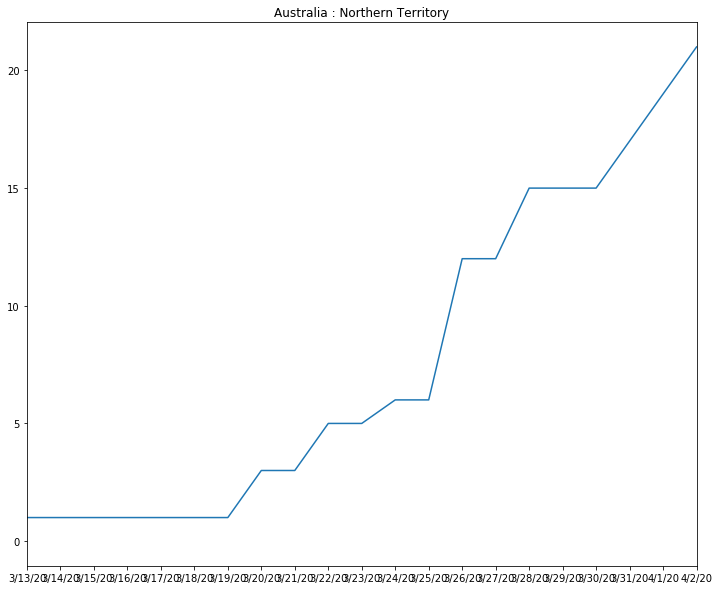

In [131]:
plotGraph('Australia : Northern Territory')
train_set,test_set = test_train('Australia : Northern Territory',7,50)

In [157]:
class LSTMcell(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 50, output_size = 1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        self.hidden = (torch.zeros(1,1,self.hidden_size), torch.zeros(1,1,self.hidden_size))
        
    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]

In [158]:
model = LSTMcell()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
model

LSTMcell(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [159]:
scaler = PowerTransformer(method='box-cox', standardize=False)
x_norm2 = scaler.fit_transform(train_set.reshape(-1,1))
train_norms = torch.FloatTensor(x_norm2).view(-1)
    

In [79]:
train_data

[(tensor([0., 0., 0., 0., 0.]), tensor([0.])),
 (tensor([0., 0., 0., 0., 0.]), tensor([0.])),
 (tensor([0., 0., 0., 0., 0.]), tensor([0.])),
 (tensor([0., 0., 0., 0., 0.]), tensor([0.9375])),
 (tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.9375]), tensor([0.9375])),
 (tensor([0.0000, 0.0000, 0.0000, 0.9375, 0.9375]), tensor([1.2797])),
 (tensor([0.0000, 0.0000, 0.9375, 0.9375, 1.2797]), tensor([1.2797])),
 (tensor([0.0000, 0.9375, 0.9375, 1.2797, 1.2797]), tensor([1.3898])),
 (tensor([0.9375, 0.9375, 1.2797, 1.2797, 1.3898]), tensor([1.3898])),
 (tensor([0.9375, 1.2797, 1.2797, 1.3898, 1.3898]), tensor([1.7580])),
 (tensor([1.2797, 1.2797, 1.3898, 1.3898, 1.7580]), tensor([1.7580])),
 (tensor([1.2797, 1.3898, 1.3898, 1.7580, 1.7580]), tensor([1.8613]))]

In [160]:
epochs = 10
losses = []
train_data = input_data(train_norms,7)
for i in range(epochs):
    for seq, y_train in train_data:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size), torch.zeros(1,1,model.hidden_size))
        y_pred = model(seq)
        loss = torch.sqrt(criterion(y_pred, y_train))
        loss.backward()
        optimizer.step()
    print(f'epoch: {i} loss: {loss.item()}')
    losses.append(loss.item())


epoch: 0 loss: 1.4241119623184204
epoch: 1 loss: 1.2943586111068726
epoch: 2 loss: 1.1341631412506104
epoch: 3 loss: 0.8784210681915283
epoch: 4 loss: 0.397988498210907
epoch: 5 loss: 0.14142930507659912
epoch: 6 loss: 0.2166358232498169
epoch: 7 loss: 0.08552849292755127
epoch: 8 loss: 0.12294256687164307
epoch: 9 loss: 0.10813760757446289


In [161]:
window_size = 7
future = 7
pred = train_norms[-window_size:].tolist()
for i in range(future):
    with torch.no_grad():
        seq = torch.FloatTensor(pred[-window_size:])
        model.hidden = (torch.zeros(1,1,model.hidden_size), torch.zeros(1,1,model.hidden_size))
        pred.append(model(seq).item())
    

In [162]:
pred[-7:]

[1.3748762607574463,
 1.4074329137802124,
 1.438897728919983,
 1.459157943725586,
 1.4792824983596802,
 1.4960062503814697,
 1.5120047330856323]

In [163]:
z = scaler.inverse_transform(np.array(pred).reshape(-1,1))

In [164]:
z

array([[ 2.99999986],
       [ 2.99999986],
       [ 5.00000069],
       [ 5.00000069],
       [ 6.00000092],
       [ 6.00000092],
       [11.99999748],
       [11.76562954],
       [13.32560891],
       [15.15574198],
       [16.54614679],
       [18.13031557],
       [19.6307077 ],
       [21.25158897]])

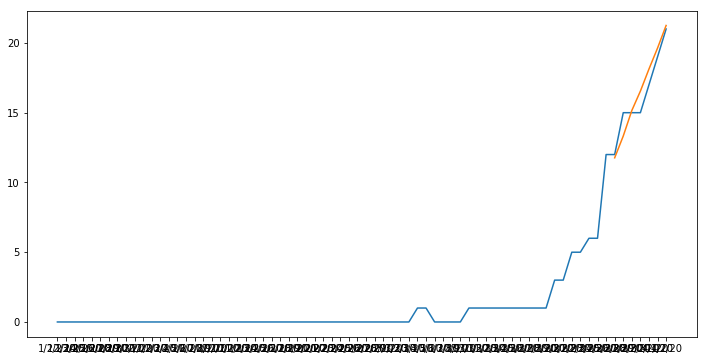

In [165]:
plt.figure(figsize=(12,6))
plt.plot(df2['Australia : Northern Territory'])
plt.plot(['3/27/20','3/28/20','3/29/20','3/30/20','3/31/20','4/1/20','4/2/20'],z[-7:])


In [166]:
torch.save(model.state_dict(), "../Extra Data/covidFor7PointsInsteadof5.pt")